In [1]:
import os

# Change to the parent directory
os.chdir('..')
from utils.visualizer import SoccerVisualizer
import torch
import numpy as np

FEATURE_DIR = 'data/soccer_shards'
TARGET_DIR = 'data/soccer_shards_targets'

visualizer = SoccerVisualizer()

In [2]:
def load_first_shard():
    fpaths = sorted([os.path.join(FEATURE_DIR, f) for f in os.listdir(FEATURE_DIR) if f.endswith(".pt")])
    tpaths = sorted([os.path.join(TARGET_DIR,  f) for f in os.listdir(TARGET_DIR)  if f.endswith(".pt")])
    if not fpaths or not tpaths:
        raise FileNotFoundError("No shard .pt files found.")

    feats = torch.load(fpaths[0], map_location="cpu")['X']  # (C, N, W, H)
    targs = torch.load(tpaths[0],  map_location="cpu")['targets'] # (N, 3) or (3, N)
    if targs.dim() == 2 and targs.shape[0] == 3 and targs.shape[1] != 3:
        targs = targs.t().contiguous()
    assert feats.dim() == 4 and targs.dim() == 2 and targs.shape[1] == 3
    return feats, targs

def get_example(feats_cnwH, targs_n3, i):
    C, N, W, H = feats_cnwH.shape
    if i < 0 or i >= N:
        raise IndexError(f"Index {i} out of range (N={N}).")
    x = feats_cnwH[:, i, :, :]        # (C, W, H)
    # Ensure (C, H, W) = (C, 105, 68)
    if x.shape[-2] in (68, 34, 17) and x.shape[-1] in (105, 52, 26):
        x = x.permute(0, 2, 1).contiguous()
    dst_xy = targs_n3[i, :2].clone()  # (x, y)
    y      = targs_n3[i, 2].clone()   # 0/1
    return x, dst_xy, y

In [3]:
feats, targs = load_first_shard()


## Voronoi Diagram

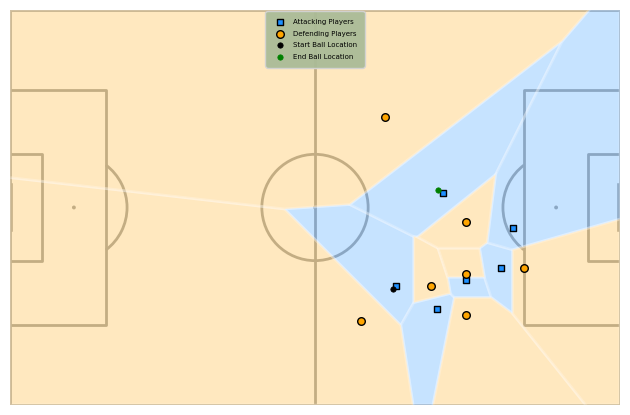

In [4]:

EXAMPLE_IDX = np.random.randint(0,20000)

x_c_hw, dst_xy, y = get_example(feats, targs, EXAMPLE_IDX)
in_pos  = (x_c_hw[3] > 0).to(torch.float32)   # (105, 68)
out_pos = (x_c_hw[4] > 0).to(torch.float32)   # (105, 68)
ball_dist = (x_c_hw[0]).to(torch.float32)   # note: >0, not ==0

fig, ax, _ = visualizer.plot_state(
        in_possession=in_pos,   # empty overlays
        out_possession=out_pos,
        show_voronoi=True,
    )

dst_x = float(dst_xy[0].item())
dst_y = float(dst_xy[1].item())

flat_idx = torch.argmin(ball_dist)
yy = (flat_idx // ball_dist.shape[1]).item()
x = (flat_idx %  ball_dist.shape[1]).item()
bx, by = float(yy), float(x)

if y ==1:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="green", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

else:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="red", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

legend = ax.legend(
    loc="upper center",
    frameon=True,
    facecolor="#aabb97",
    edgecolor="lightgray",
    fontsize=5,
    labelspacing=0.8,
    borderpad=0.8,
    handletextpad=0.8,
)

# round the legend box corners
legend.get_frame().set_boxstyle("round,pad=0.4")
legend.get_frame().set_alpha(0.95)



## Next

In [16]:
import torch
from typing import Tuple, Optional

def gaussian_control(
    atk_1hot: torch.Tensor,   # (H,W) or (B,H,W) or (B,1,H,W)
    def_1hot: torch.Tensor,   # same shape
    H: int = 105,
    W: int = 68,
    sigma: float = 6.0,       # gaussian width in grid cells
    alpha: float = 1e-7,      # neutral prior strength (Fix #1)
    eps: float = 1e-8,
    return_evidence: bool = False,
) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    """
    Pure Gaussian pitch-control map with:
      (1) neutral constant prior everywhere
      (5) evidence-based blending to 0.5 in empty space

    Output:
      control: (H,W) or (B,H,W) in [0,1]
      evidence (optional): same shape, confidence of control
    """

    # ---- normalize shapes to (B,H,W)
    if atk_1hot.dim() == 2:
        atk = atk_1hot.unsqueeze(0)
        deff = def_1hot.unsqueeze(0)
        squeeze_out = True
    elif atk_1hot.dim() == 4:  # (B,1,H,W)
        atk = atk_1hot.squeeze(1)
        deff = def_1hot.squeeze(1)
        squeeze_out = False
    else:
        atk = atk_1hot
        deff = def_1hot
        squeeze_out = False

    assert atk.shape == deff.shape
    B, HH, WW = atk.shape
    assert (HH, WW) == (H, W)
    device = atk.device

    # ---- grid coordinates (HW,2) in (y,x)
    yy, xx = torch.meshgrid(
        torch.arange(H, device=device),
        torch.arange(W, device=device),
        indexing="ij",
    )
    grid = torch.stack([yy.reshape(-1), xx.reshape(-1)], dim=-1).float()

    sigma2 = float(sigma) ** 2
    inv_two_sigma2 = 1.0 / (2.0 * sigma2)

    controls = []
    evidences = []

    for b in range(B):
        atk_pts = torch.nonzero(atk[b] > 0, as_tuple=False).float()
        def_pts = torch.nonzero(deff[b] > 0, as_tuple=False).float()

        # ---- sum of Gaussians
        if atk_pts.numel() == 0:
            Ap = torch.zeros((H * W,), device=device)
        else:
            dA2 = torch.cdist(grid, atk_pts) ** 2
            Ap = torch.exp(-dA2 * inv_two_sigma2).sum(dim=1)

        if def_pts.numel() == 0:
            Dp = torch.zeros((H * W,), device=device)
        else:
            dD2 = torch.cdist(grid, def_pts) ** 2
            Dp = torch.exp(-dD2 * inv_two_sigma2).sum(dim=1)

        # ---- Fix (1): neutral prior
        A = Ap + alpha
        D = Dp + alpha

        # base control
        control = A / (A + D + eps)

        # ---- Fix (5): evidence-based blending
        evidence = Ap + Dp
        evidence = evidence / (evidence.max() + eps)  # normalize per-frame

        control = evidence * control + (1.0 - evidence) * 0.5

        controls.append(control.view(H, W))
        evidences.append(evidence.view(H, W))

    control = torch.stack(controls, dim=0)
    evidence = torch.stack(evidences, dim=0)

    if squeeze_out:
        control = control[0]
        evidence = evidence[0]

    return (control, evidence) if return_evidence else (control, None)


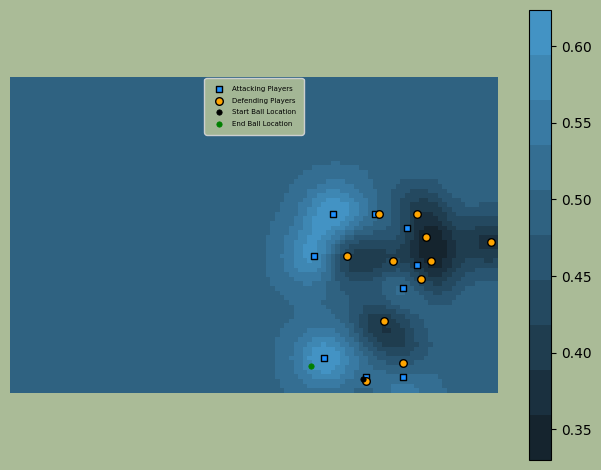

In [36]:

EXAMPLE_IDX = 9569#np.random.randint(0,20000)

feats, targs = load_first_shard()
x_c_hw, dst_xy, y = get_example(feats, targs, EXAMPLE_IDX)
in_pos  = (x_c_hw[3] > 0).to(torch.float32)   # (105, 68)
out_pos = (x_c_hw[4] > 0).to(torch.float32)   # (105, 68)
ball_dist = (x_c_hw[0]).to(torch.float32)   # note: >0, not ==0

test,_ = gaussian_control(in_pos,out_pos,sigma=4.5)



fig, ax, _ = visualizer.plot_state(
        in_possession=in_pos,   # empty overlays
        out_possession=out_pos,
        show_voronoi=False,
        heatmap=test
    )

dst_x = float(dst_xy[0].item())
dst_y = float(dst_xy[1].item())

flat_idx = torch.argmin(ball_dist)
yy = (flat_idx // ball_dist.shape[1]).item()
x = (flat_idx %  ball_dist.shape[1]).item()
bx, by = float(yy), float(x)

if y ==1:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="green", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

else:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="red", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

legend = ax.legend(
    loc="upper center",
    frameon=True,
    facecolor="#aabb97",
    edgecolor="lightgray",
    fontsize=5,
    labelspacing=0.8,
    borderpad=0.8,
    handletextpad=0.8,
)

# round the legend box corners
legend.get_frame().set_boxstyle("round,pad=0.4")
legend.get_frame().set_alpha(0.95)



In [7]:
import torch
from typing import Tuple

def boundary_distance_map(H: int = 105, W: int = 68, device=None, dtype=torch.float32) -> torch.Tensor:
    """
    (H,W) map: each cell = distance (in grid cells) to the nearest pitch boundary
    (top/bottom/left/right edges).
    """
    device = device or torch.device("cpu")
    yy, xx = torch.meshgrid(
        torch.arange(H, device=device, dtype=dtype),
        torch.arange(W, device=device, dtype=dtype),
        indexing="ij",
    )
    dist_top = yy
    dist_bottom = (H - 1) - yy
    dist_left = xx
    dist_right = (W - 1) - xx
    return torch.minimum(torch.minimum(dist_top, dist_bottom), torch.minimum(dist_left, dist_right))


def centerline_distance_map(H: int = 105, W: int = 68, center_x: float = 34.0, device=None, dtype=torch.float32) -> torch.Tensor:
    """
    (H,W) map: each cell = absolute distance (in grid cells) to the vertical centerline
    x = center_x (running along the 105-length axis).
    For W=68, the midline is at x=34 (between 33 and 34 in 0-indexed space).
    """
    device = device or torch.device("cpu")
    xx = torch.arange(W, device=device, dtype=dtype).view(1, W).expand(H, W)
    return (xx - center_x).abs()


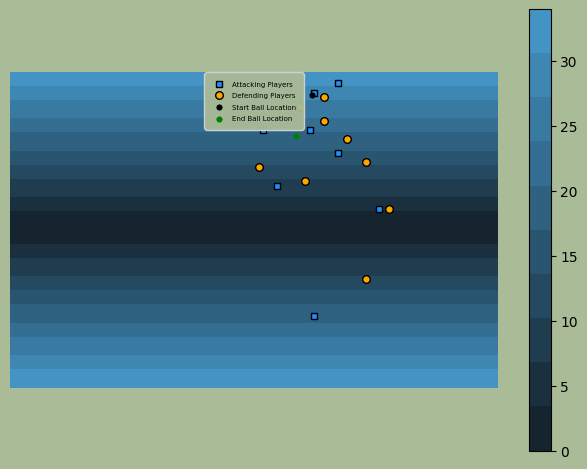

In [8]:

EXAMPLE_IDX = np.random.randint(0,20000)

feats, targs = load_first_shard()
x_c_hw, dst_xy, y = get_example(feats, targs, EXAMPLE_IDX)
in_pos  = (x_c_hw[3] > 0).to(torch.float32)   # (105, 68)
out_pos = (x_c_hw[4] > 0).to(torch.float32)   # (105, 68)
ball_dist = (x_c_hw[0]).to(torch.float32)   # note: >0, not ==0

test = centerline_distance_map()



fig, ax, _ = visualizer.plot_state(
        in_possession=in_pos,   # empty overlays
        out_possession=out_pos,
        show_voronoi=False,
        heatmap=test
    )

dst_x = float(dst_xy[0].item())
dst_y = float(dst_xy[1].item())

flat_idx = torch.argmin(ball_dist)
yy = (flat_idx // ball_dist.shape[1]).item()
x = (flat_idx %  ball_dist.shape[1]).item()
bx, by = float(yy), float(x)

if y ==1:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="green", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

else:
    ax.scatter([bx], [by], c="black", s=15, marker="o", zorder=5, linewidths=0.5,label = 'Start Ball Location')
    ax.scatter([dst_x], [dst_y], c="red", s=15, marker="o", zorder=5, linewidths=0.5,label = 'End Ball Location')

legend = ax.legend(
    loc="upper center",
    frameon=True,
    facecolor="#aabb97",
    edgecolor="lightgray",
    fontsize=5,
    labelspacing=0.8,
    borderpad=0.8,
    handletextpad=0.8,
)

# round the legend box corners
legend.get_frame().set_boxstyle("round,pad=0.4")
legend.get_frame().set_alpha(0.95)

